<a href="https://colab.research.google.com/github/Feindrial/bondnet/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split as sk_tt_split
import surprise as sp
from surprise.model_selection import cross_validate, train_test_split as sp_tt_split
from surprise import Dataset, Reader
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import LSTM
from keras.layers import Dense, Flatten
from keras import Input
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

locc = "LOCAL"

if locc == "LOCAL":

    #veri setinin indirilip dosya yollarının kaydedilmesi

    movielens_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

    downloaded_path = tf.keras.utils.get_file(movielens_url.rsplit('/').pop(), movielens_url, extract=True)

    dataset_dir = Path(downloaded_path).parent / Path(downloaded_path).stem
    print(dataset_dir)

    #indirelen veri setinin ilgili csv dosyaları pandas dataframe olarak atandı

elif locc == "COLAB":

    dataset_dir = Path("/content")
    print(dataset_dir)

    ! pip install -q kaggle
    from google.colab import files
    files.upload()

    ! mkdir ~/.kaggle
    ! mv kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json

    !kaggle datasets download "shubhammehta21/movie-lens-small-latest-dataset"
    !unzip -j "movie-lens-small-latest-dataset"

else:
    raise RuntimeError

2.12.0
C:\Users\feind\.keras\datasets\ml-latest-small


In [3]:
ratings_file = dataset_dir / "ratings.csv"
ratings = pd.read_csv(
    ratings_file
)

movies_file = dataset_dir / "movies.csv"
movies = pd.read_csv(
    movies_file
)

In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [7]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


<Axes: xlabel='rating'>

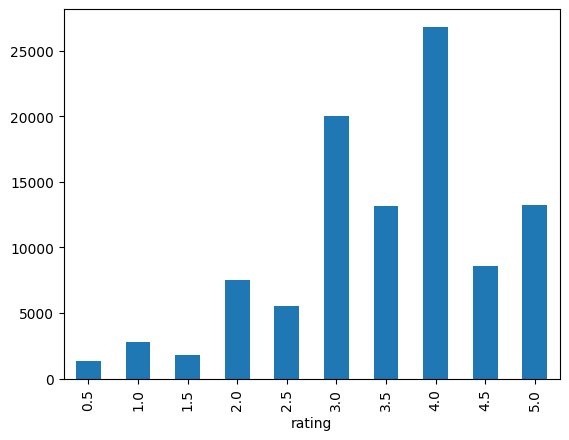

In [8]:
ratings["rating"].value_counts().sort_index().plot.bar()

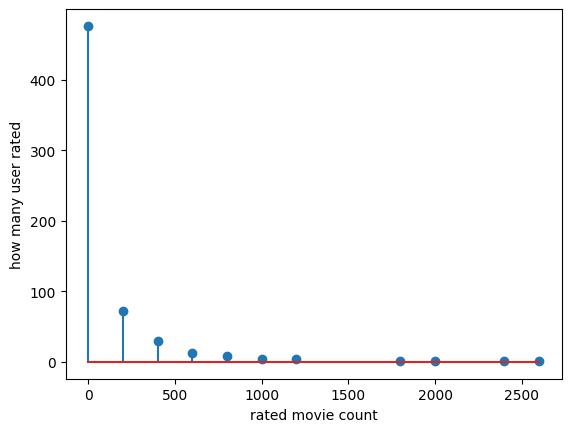

In [9]:
u200 = np.unique(ratings["userId"].value_counts().to_numpy() // 200 * 200, return_counts=True)

fig, ax = plt.subplots()
ax.stem(u200[0], u200[1])
ax.set_xlabel('rated movie count')
ax.set_ylabel('how many user rated')
plt.show()

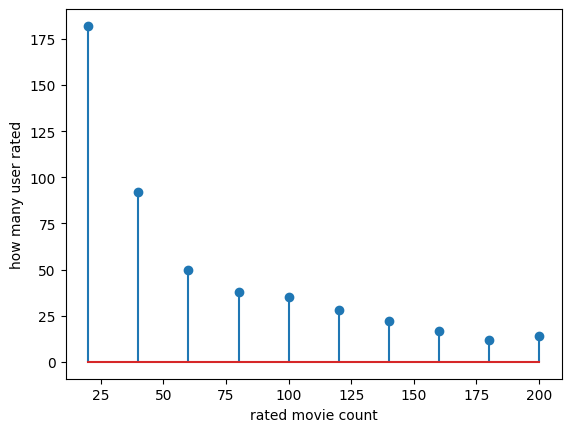

In [10]:
u20 = np.unique(ratings["userId"].value_counts().to_numpy() // 20 * 20, return_counts=True)
u20x = u20[0][:10]
u20y = u20[1][:10]
fig, ax = plt.subplots()
ax.stem(u20x, u20y)
ax.set_xlabel('rated movie count')
ax.set_ylabel('how many user rated')
plt.show()

<Axes: >

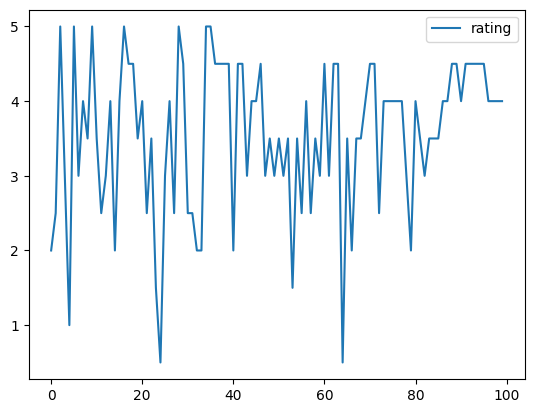

In [17]:
uidplt = ratings.iloc[np.random.randint(len(ratings))]["userId"]
uidrt = ratings[ratings["userId"] == uidplt].sort_values(by=["timestamp"])[["timestamp", "rating"]]
uidrt.set_index(np.arange(len(uidrt))).drop(["timestamp"], axis=1).iloc[:100].plot()

In [18]:
ratings["rating"].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [4]:
ratings["userId"].value_counts().describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: count, dtype: float64

In [4]:
movies = movies.drop(["genres", "title"], axis=1)
movies.head(3)

,movieId
0,1
1,2
2,3


In [5]:
ratings = ratings.join(movies.set_index("movieId"), on="movieId", how="inner")
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
516,5,1,4.0,847434962
874,7,1,4.5,1106635946
1434,15,1,2.5,1510577970
1667,17,1,4.5,1305696483


In [6]:
ratings = ratings.sort_values(['userId', 'timestamp'], ascending=[True, True])
ratings.head(5)

,userId,movieId,rating,timestamp
43,1,804,4.0,964980499
73,1,1210,5.0,964980499
120,1,2018,5.0,964980523
171,1,2628,4.0,964980523
183,1,2826,4.0,964980523


In [7]:
ratings.rename(columns={"userId":"user_id", "movieId":"item_id"}, inplace=True)

In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100836 entries, 43 to 99775
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    100836 non-null  int64  
 1   item_id    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.8 MB


In [106]:
class BondNet(keras.Model):
    def __init__(self, data: pd.DataFrame, embedding_size=32, batch_size=32, window_length=32, **kwds):
        super(BondNet, self).__init__(**kwds)

        self.out_cat_size = 10
        self.embedding_size = embedding_size
        self.batch_size = batch_size
        self.window_length = window_length

        self.data = data.copy()
        #self.data.loc[-1] = [-1, -1, -1.0, -1] #padding data

        self.user_size = self.data["user_id"].nunique()
        self.item_size = self.data["item_id"].nunique()

        reader = Reader(rating_scale=(1, 5))
        sdata = Dataset.load_from_df(self.data.drop(["timestamp"], axis=1), reader)
        surprise_X, _ = sp_tt_split(sdata, test_size=0.1e-99)

        self.svdpp = sp.SVDpp(n_factors=embedding_size, cache_ratings=True)
        self.svdpp.fit(surprise_X)

        # pad_embed_user = self.svdpp.pu[-1]
        # pad_embed_item = self.svdpp.qi[-1]
        # pad_user_bias = self.svdpp.bu[-1]
        # pad_item_bias = self.svdpp.bi[-1]
        # pad_rating = self.data.iloc[-1]["rating"]

        self.user_embedsvd_map = {i:index for index, i in enumerate(np.sort(self.data["user_id"].unique()))}
        self.item_embedsvd_map = {u:index for index, u in enumerate(np.sort(self.data["item_id"].unique()))}
        self.data, self.user_split_map = self.__split_data(self.data)
        
        self.train, self.val, self.test = self.__split_users(self.data["user_id"].unique())
        np.random.shuffle(self.train)
        np.random.shuffle(self.val)
        np.random.shuffle(self.test)

        
        # self.user_index_query = np.sort(self.data["user_id"].unique())
        # self.item_index_query = np.sort(self.data["item_id"].unique())
        # self.shuffled_users = self.data["user_id"].unique()
        # np.random.shuffle(self.shuffled_users)

        


        self.ohe = OneHotEncoder()
        self.ohe.fit(self.data["rating"].values.reshape(-1, 1))
        # y_md = np.asanyarray(dylist)
        # y_md = np.reshape(y_md, ((len(y_md), 1))) 
        # print(y_md)

        # self.X = np.asanyarray(dxlist)
        # self.y = ohe.fit_transform(y_md).toarray()

        self.input_id_to_vec = keras.layers.Input(shape=(self.window_length - 1, self.embedding_size * 2 + 2), batch_size=self.batch_size, name="Id2Vec input")
        self.input_id_embeddings = keras.layers.Input(shape=(self.window_length - 1 + 2), batch_size=self.batch_size, name="Embeddings info input")
        self.input_ratings = keras.layers.Input(shape=(self.window_length - 1, 1, self.out_cat_size), batch_size=self.batch_size, name="Ratings input")

        self.user_embed = keras.layers.Embedding(self.user_size, self.embedding_size, embeddings_initializer="random_normal", embeddings_regularizer=keras.regularizers.L1L2())
        self.item_embed = keras.layers.Embedding(self.item_size, self.embedding_size, embeddings_initializer="random_normal", embeddings_regularizer=keras.regularizers.L1L2())
        self.user_bias = keras.layers.Embedding(self.user_size, self.out_cat_size, embeddings_initializer="random_normal", embeddings_regularizer=keras.regularizers.L1L2())
        self.item_bias = keras.layers.Embedding(self.item_size, self.out_cat_size, embeddings_initializer="random_normal", embeddings_regularizer=keras.regularizers.L1L2())

        self.pred_user_item_dense1 = keras.layers.Dense(512, activation="relu")
        self.pred_user_item_dense_dropout1 = keras.layers.Dropout(0.4)
        self.pred_user_item_dense2 = keras.layers.Dense(256, activation="relu")
        self.pred_user_item_dense_dropout2 = keras.layers.Dropout(0.4)
        self.pred_user_item_output_dense = keras.layers.Dense(self.out_cat_size, activation=None)
        self.pred_user_item_output = keras.layers.Activation("softmax")

        self.embed_user_item_rating_lstm1 = keras.layers.LSTM(64, return_sequences=True)
        self.embed_user_item_rating_lstm2 = keras.layers.LSTM(64)

        self.time_based_dense1 = keras.layers.Dense(256, activation="relu")
        self.time_based_dense_dropout1 = keras.layers.Dropout(0.4)
        self.time_based_dense2 = keras.layers.Dense(256, activation="relu")
        self.time_based_dense_dropout2 = keras.layers.Dropout(0.4)
        self.time_based_output_dense = keras.layers.Dense(self.out_cat_size, activation=None)
        self.time_based_output = keras.layers.Activation("softmax")  

    def train_spe(self):
        return len(self.train) // self.batch_size
    def val_spe(self):
        return len(self.val) // self.batch_size
    def test_spe(self):
        return len(self.test) // self.batch_size

    def __split_users(self, users: np.ndarray):
        data_split_map = {}
        for k, v in self.user_split_map.items():
            if v not in data_split_map:
                data_split_map[v] = [k]
            else:
                data_split_map[v].append(k)

        intial_users = []
        for k, v in data_split_map.items():
            index = np.random.choice(len(v), 1)[0]
            intial_users.append(v[index])
            del data_split_map[k][index]

        remaining_users = []
        for v in data_split_map.values():
            for value in v:
                remaining_users.append(value)

        real_test_size = 0.3
        real_val_size_from_size = 1.0 / 3.0
        real_test_size = (len(intial_users) + len(remaining_users)) * real_test_size
        train_remaining, test = sk_tt_split(remaining_users, test_size=real_test_size / len(remaining_users))
        test, val = sk_tt_split(test, test_size=real_val_size_from_size)

        for iu in intial_users:
            train_remaining.append(iu)

        return train_remaining, val, test

    def __split_data(self, data: pd.DataFrame):
        pratings = pd.DataFrame(columns=data.columns)
        user_split_map = {}
        user_id_count = np.max(data["user_id"].values) + 1
        for u in data["user_id"].unique():
        
            islice = 0
            temp_data = data[data["user_id"] == u].sort_values(['timestamp'], ascending=[True])
            while islice < len(temp_data):
                tdata = temp_data[islice:islice + self.window_length]

                if islice != 0:
                    tdata.loc[:, "user_id"] = tdata.loc[:, "user_id"].replace(u, user_id_count)
                    user_id_count += 1

                if len(tdata) == self.window_length:
                    pratings = pd.concat([pratings, tdata])
                    user_split_map[tdata["user_id"].iloc[0]] = u

                islice += self.window_length

        return pratings, user_split_map
        
    def __data_gen(self, type):
        dxid2vec = []
        dxembed = []
        dxrating = []
        dybatch = []

        if type == "TRAIN":
            udata = self.train
        elif type == "VAL":
            udata = self.val
        elif type == "TEST":
            udata = self.test
        else:
            raise RuntimeError

        for u in udata:
            temp_data = self.data[self.data["user_id"] == u]
            dxid2vecfull = []
            dxembedhalf = []
            dxratinghalf = []
            u_index = self.user_embedsvd_map[self.user_split_map[u]]
            for i in temp_data["item_id"].values[:-1]:
                dxid2vechalf = []
                i_index = self.item_embedsvd_map[i]
                dxid2vechalf.append([self.svdpp.pu[u_index], self.svdpp.qi[i_index]])
                dxid2vechalf = np.asanyarray(dxid2vechalf).flatten().tolist()
                dxid2vechalf.append(self.svdpp.bu[u_index])
                dxid2vechalf.append(self.svdpp.bi[i_index])
                dxid2vecfull.append(np.asanyarray(dxid2vechalf))
                dxembedhalf.append(i_index)
                dxratinghalf.append(self.ohe.transform(np.reshape(self.data[(self.data["user_id"] == u) & (self.data["item_id"] == i)]["rating"], (-1, 1))).toarray())

            #dxembedhalf.append(temp_data["item_id"].values[:-1])
            dxembedhalf = np.asanyarray(dxembedhalf).flatten().tolist()
            dxembedhalf.append(u_index)
            dxembedhalf.append(self.item_embedsvd_map[temp_data["item_id"].values[-1]])
            dxembed.append(np.asanyarray(dxembedhalf))
            dxrating.append(np.asanyarray(dxratinghalf))
            dxid2vec.append(np.asanyarray(dxid2vecfull))
            dybatch.append(np.asanyarray(self.ohe.transform(temp_data.iloc[-1]["rating"].reshape(-1, 1)).toarray()))

            if len(dxid2vec) == self.batch_size:
                yield (np.asanyarray(dxid2vec, dtype=np.float32), np.asanyarray(dxembed, dtype=np.int32), np.asanyarray(dxrating, dtype=np.float32)), np.asanyarray(dybatch, dtype=np.float32)
                dxid2vec = []
                dxembed = []
                dxrating = []
                dybatch = []
        
        # if len(dxid2vec) != 0:
        #     yield (np.asanyarray(dxid2vec, dtype=np.float32), np.asanyarray(dxembed, dtype=np.int32), np.asanyarray(dxrating, dtype=np.float32)), np.asanyarray(dybatch, dtype=np.float32)
        #     dxid2vec = []
        #     dxembed = []
        #     dxrating = []
        #     dybatch = []

            

    def get_dataset(self):
        signature = ((tf.TensorSpec(shape=(self.batch_size, self.window_length - 1, self.embedding_size * 2 + 2), dtype=tf.float32),
                      tf.TensorSpec(shape=(self.batch_size, self.window_length - 1 + 2), dtype=tf.int32),
                      tf.TensorSpec(shape=(self.batch_size, self.window_length - 1, 1, len(self.ohe.categories_[0])), dtype=tf.float32)),
                      tf.TensorSpec(shape=(self.batch_size, 1, len(self.ohe.categories_[0])), dtype=tf.float32))

        train_dataset = tf.data.Dataset.from_generator(
            lambda: self.__data_gen("TRAIN"),
            output_signature=signature
        )

        val_dataset = tf.data.Dataset.from_generator(
            lambda: self.__data_gen("VAL"),
            output_signature=signature
        )

        test_dataset = tf.data.Dataset.from_generator(
            lambda: self.__data_gen("TEST"),
            output_signature=signature
        )

        return train_dataset, val_dataset, test_dataset
    
    def call(self, inputs):
        id2vecs = inputs[0]
        users = inputs[1][:, -2]
        pred_items = inputs[1][:, -1]
        embed_items = inputs[1][:, :-2]
        ratings = tf.reshape(inputs[2], (self.batch_size, self.window_length - 1, self.out_cat_size))

        #EMBEDDING API
        embed_users_vector = self.user_embed(users)
        embed_users_bias = self.user_bias(users)
        embed_items_vector = self.item_embed(embed_items)
        embed_items_bias = self.item_bias(embed_items)
        embed_pred_items_vector = self.item_embed(pred_items)
        embed_pred_items_bias = self.item_bias(pred_items)

        

        # print("biases")
        # # print(users_bias.shape)
        # print(embed_items_bias.shape)
        # print(embed_pred_items_bias.shape)
        # print("vecs")
        # # print(users_vector.shape)
        # print(embed_items_vector.shape)
        # print(embed_pred_items_vector.shape)
        # print("rating", ratings.shape)
        embed_items_bias = tf.reduce_sum(embed_items_bias, axis=1)
        item_biases = (embed_items_bias + embed_pred_items_bias) / float(self.window_length - 1 + 1)
        biases = item_biases + embed_users_bias

        user_item_pred_vector = tf.concat((embed_users_vector, embed_pred_items_vector), axis=1)
        user_item_pred_output = self.pred_user_item_dense_dropout1(self.pred_user_item_dense1(user_item_pred_vector))
        user_item_pred_output = self.pred_user_item_dense_dropout2(self.pred_user_item_dense2(user_item_pred_output))
        user_item_pred_output = self.pred_user_item_output_dense(user_item_pred_output)
        user_item_pred_output = user_item_pred_output + biases
        user_item_pred_output = self.pred_user_item_output(user_item_pred_output)

        users_repeated = tf.reshape(tf.repeat(embed_users_vector, self.window_length - 1, axis=0), (self.batch_size, self.window_length - 1, self.embedding_size))
        user_item_rating_timebased = tf.concat((users_repeated, embed_items_vector, ratings), axis=2)
        user_item_rating_timebased_vector = self.embed_user_item_rating_lstm2(self.embed_user_item_rating_lstm1(user_item_rating_timebased))

        user_item_rating_timebased_output = self.time_based_dense_dropout1(self.time_based_dense1(user_item_rating_timebased_vector))
        user_item_rating_timebased_output = self.time_based_dense_dropout2(self.time_based_dense2(user_item_rating_timebased_output))
        user_item_rating_timebased_output = self.time_based_output_dense(user_item_rating_timebased_output)
        user_item_rating_timebased_output = user_item_rating_timebased_output + biases
        user_item_rating_timebased_output = self.time_based_output(user_item_rating_timebased_output)

        return tf.reshape((user_item_pred_output + user_item_rating_timebased_output) / 2.0, (self.batch_size, 1, self.out_cat_size))

In [107]:
bn = BondNet(ratings, embedding_size=64, batch_size=32, window_length=50)

In [108]:
tr, val, te = bn.get_dataset()

In [28]:
for t in tr:
    print(t)
    break

tf.Tensor(
[[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]], shape=(2, 1, 10), dtype=float32)


In [109]:
bn.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.95),
    metrics=[
        keras.metrics.MeanSquaredError(),
        keras.metrics.RootMeanSquaredError(),
        keras.metrics.CategoricalAccuracy()
    ]
)

In [110]:
history = bn.fit(
    tr.repeat(),
    validation_data=val.repeat(),
    #batch_size=bn.batch_size,
    steps_per_epoch=bn.train_spe(),
    validation_steps=bn.val_spe(),
    epochs=10
)

Epoch 1/10
37/37 [==============================] - 1006s 27s/step - loss: 2.2250 - mean_squared_error: 0.0883 - root_mean_squared_error: 0.2972 - categorical_accuracy: 0.2255 - val_loss: 2.1015 - val_mean_squared_error: 0.0854 - val_root_mean_squared_error: 0.2922 - val_categorical_accuracy: 0.2875
Epoch 2/10
37/37 [==============================] - 973s 27s/step - loss: 2.0458 - mean_squared_error: 0.0845 - root_mean_squared_error: 0.2907 - categorical_accuracy: 0.2703 - val_loss: 1.9941 - val_mean_squared_error: 0.0831 - val_root_mean_squared_error: 0.2883 - val_categorical_accuracy: 0.2875
Epoch 3/10
37/37 [==============================] - 999s 28s/step - loss: 1.9912 - mean_squared_error: 0.0834 - root_mean_squared_error: 0.2889 - categorical_accuracy: 0.2669 - val_loss: 1.9744 - val_mean_squared_error: 0.0830 - val_root_mean_squared_error: 0.2882 - val_categorical_accuracy: 0.3000
Epoch 4/10
37/37 [==============================] - 1160s 32s/step - loss: 1.9587 - mean_squared_er

KeyboardInterrupt: 

In [75]:
eval = bn.evaluate(
    te,
    batch_size=bn.batch_size,
    steps=bn.test_spe()
)

6/6 [==============================] - 3s 456ms/step - loss: 2.1283 - mean_squared_error: 0.0862 - root_mean_squared_error: 0.2935 - categorical_accuracy: 0.2500


In [65]:
bn.predict(te.as_numpy_iterator().next()[0])

1/1 [==============================] - 2s 2s/step


array([[[0.02499004, 0.03911908, 0.03241139, 0.07614801, 0.03831066,
         0.15902692, 0.17219613, 0.27851704, 0.06501711, 0.11426367]],

       [[0.02388486, 0.04143833, 0.03425407, 0.07812206, 0.03808202,
         0.15098004, 0.17327502, 0.28224576, 0.06606241, 0.1116554 ]]],
      dtype=float32)

In [199]:
bn.summary()

Model: "bond_net_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    multiple                  2440      
                                                                 
 embedding_61 (Embedding)    multiple                  38896     
                                                                 
 embedding_62 (Embedding)    multiple                  6100      


                                                                 
 embedding_63 (Embedding)    multiple                  97240     
                                                                 
 dense_79 (Dense)            multiple                  144       
                                                                 
 dense_80 (Dense)            multiple                  136       
                                                                 
 dense_81 (Dense)            multiple                  90        
                                                                 
 lstm_38 (LSTM)              multiple                  368       
                                                                 
 lstm_39 (LSTM)              multiple                  144       
                                                                 
 dense_82 (Dense)            multiple                  80        
                                                                 
 dense_83 